In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import glob
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
ROOT_DIR = '../data/instacart/files/'

In [3]:
print('loading prior')
priors = pd.read_csv(ROOT_DIR+'order_products__prior.csv', dtype={
    'order_id':np.int32,
    'product_id':np.uint16,
    'add_to_cart_order':np.int16,
    'reordered':np.int8
})

print('loading train')
train = pd.read_csv(ROOT_DIR+'order_products__train.csv', dtype={
    'order_id':np.int32,
    'product_id':np.uint16,
    'add_to_cart_order':np.int16,
    'reordered':np.int8
})

print('loading orders')
orders = pd.read_csv(ROOT_DIR+'orders.csv', dtype={
    'order_id':np.int32,
    'user_id':np.int32,
    'eval_set':'category',
    'order_number':np.int16,
    'order_dow':np.int8,
    'order_hour_of_day':np.int8,
    'days_since_prior_order':np.float32
})

print('loading products')
products = pd.read_csv(ROOT_DIR+'products.csv', dtype={
    'product_id':np.uint16,
    'order_id':np.int32,
    'department_id':np.uint8}, usecols=['product_id', 'aisle_id', 'department_id'])

print('priors {}:{}'.format(priors.shape, ','.join(priors.columns)))
print('orders {}:{}'.format(orders.shape, ','.join(orders.columns)))
print('train {}:{}'.format(train.shape, ','.join(train.columns)))


loading prior
loading train
loading orders
loading products
priors (32434489, 4):order_id,product_id,add_to_cart_order,reordered
orders (3421083, 7):order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
train (1384617, 4):order_id,product_id,add_to_cart_order,reordered


#### Joining and Preprocessing

In [4]:
print('add orders info to priors and train')
orders.set_index('order_id', inplace=True, drop=False)
orders['last_order_number'] = orders.groupby('user_id')['order_number'].transform(max)
orders['order_number_reverse'] = orders['last_order_number'] - orders['order_number']
orders.drop('last_order_number', axis=1, inplace=True)

priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)

train = train.join(orders, on='order_id', rsuffix='_')
train.drop('order_id_', inplace=True, axis=1)

add orders info to priors and train


#### Functions for features

In [5]:
def get_product_features(n, reference_df, eval_set='prior' ):
    order_ids = orders.loc[(orders.order_number_reverse > n), 'order_id']
    current = reference_df[reference_df.order_id.isin(order_ids)]
    prods = pd.DataFrame()
    prods['product_orders'] = current.groupby(current.product_id).size().astype(np.int32)
    prods['product_reorders'] = current['reordered'].groupby(current.product_id).sum().astype(np.float32)
    prods['product_reorder_rate'] = (prods.product_reorders/len(order_ids)).astype(np.float32)
    prods.reset_index(inplace=True)
    prods = pd.merge(prods, products, on='product_id', how='left') 
    return prods

In [6]:
def get_user_features(n, reference_df, eval_set='prior'):
    current = orders[(orders.order_number_reverse>n)]
    grouped_df = current.groupby('user_id')
    usr = grouped_df.aggregate({'days_since_prior_order':'mean','order_number':'max','order_dow':'mean'})
    usr.rename(columns={'days_since_prior_order':'user_average_days_between_orders','order_number':'user_nb_orders',
                       'order_dow':'user_average_order_dow'}, inplace=True)
    usr['user_average_days_between_orders'] = usr['user_average_days_between_orders'].astype(np.float32)
    usr['user_nb_orders'] = usr['user_nb_orders'].astype(np.int16)
    usr['user_average_order_dow'] = usr['user_average_order_dow'].astype(np.int8)
    
    users = pd.DataFrame()
    current = reference_df[reference_df.order_number_reverse>n].groupby('user_id')
    users['user_total_items'] = current.size().astype(np.int16)
    users['user_all_products'] = current['product_id'].apply(set)
    users['user_total_distinct_items'] = users['user_all_products'].apply(len).astype(np.int16)
    users.drop('user_all_products', axis=1, inplace=True)
    users = users.join(usr)
    users.reset_index(drop=False, inplace=True)
    users['user_average_basket_size'] = (users['user_total_items']/users['user_nb_orders']).astype(np.float32)
    return users
    
    
    

In [7]:
print('compute userXproduct f -this is long ...')
priors['user_product'] = priors.product_id + priors.user_id*100000

compute userXproduct f -this is long ...


In [8]:
def get_user_product_features(n, reference_df, eval_set='prior'):
    grouped_df = reference_df[reference_df.order_number_reverse > n].groupby('user_product')
    userXproduct = grouped_df.aggregate({'user_product':'count', 'add_to_cart_order':'mean'})   
    userXproduct.rename(columns={'user_product':'UP_orders', 'add_to_cart_order':'UP_avg_pos_in_cart'}, inplace=True)
    userXproduct['user_product'] = userXproduct.index.values
    
    grouped_df = reference_df[reference_df.order_number_reverse > n].groupby('user_product')['order_number'].aggregate('max').reset_index()
    grouped_df = pd.merge(grouped_df, reference_df.loc[reference_df.order_number_reverse > n, ['user_product', 'order_number', 'order_id']],
                          on=['user_product', 'order_number'], how='left')
    userXproduct = pd.merge(userXproduct, grouped_df,on='user_product', how='left')
    userXproduct.rename(columns={'order_id':'UP_last_order_id', 'order_number':'UP_last_order_number'}, inplace=True)
    #userXproduct.index = userXproduct.user_product
    #userXproduct.drop(['order_number'], axis=1, inplace=True)
    return userXproduct

In [9]:
%time df = get_user_product_features(50, priors)

CPU times: user 1.46 s, sys: 96 ms, total: 1.56 s
Wall time: 1.55 s


In [10]:
df.head()

,UP_avg_pos_in_cart,UP_orders,user_product,UP_last_order_number,UP_last_order_id
0,5.000000,1,2700093,7,1771198
1,3.000000,1,2700633,26,2305567
2,8.000000,3,2701005,21,1149132
3,1.333333,3,2701194,30,1111867
4,7.000000,1,2701559,8,1460681


In [9]:
def features(n, reference_df, selected_orders=False, labels_given=True):
    print('build candidate set')
    if labels_given:
        current_df = reference_df.loc[reference_df.order_number_reverse == n, ['user_id','product_id']]
        current_df['user_product'] = current_df.product_id + current_df.user_id*100000 
        candidate_df = priors.loc[(priors.order_number_reverse>n)&(priors.user_id.isin(current_df.user_id)), ['user_id', 'product_id', 'user_product']].drop_duplicates('user_product')
        labels = np.in1d(candidate_df.user_product, current_df.user_product).astype(int)
    else:
        current_df = reference_df
        candidate_df = priors.loc[(priors.order_number_reverse>n)&(priors.user_id.isin(current_df.user_id)),['user_id','product_id','user_product']].drop_duplicates('user_product')
        labels=None
    
    ### Building Features
    print('Building product features')
    product_features = get_product_features(n, priors)
    train_candidates = pd.merge(candidate_df, product_features, on='product_id',how='left')
    
    print('Building user features')
    user_features = get_user_features(n, priors)
    train_candidates = pd.merge(train_candidates, user_features, on='user_id', how='left')
    
    print('Building order features')
    train_candidates = pd.merge(train_candidates, orders[orders.order_number_reverse==n], on=['user_id'], how='left')
    train_candidates['days_since_ratio'] = train_candidates.days_since_prior_order/train_candidates.user_average_days_between_orders
    ## extra cleaning step
    train_candidates['days_since_ratio'].fillna(-99, inplace=True)
    
    
    print('Building user_product features')
    user_product_features = get_user_product_features(n, priors) 
    train_candidates = pd.merge(train_candidates, user_product_features, on='user_product', how='left')
    train_candidates['UP_orders_ratio'] = train_candidates.UP_orders/train_candidates.user_nb_orders
    train_candidates['UP_orders_since_last'] = train_candidates.order_number - train_candidates.UP_last_order_number
    train_candidates['UP_delta_hour_vs_last'] = abs(train_candidates.order_hour_of_day - train_candidates.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    

    
    return train_candidates, labels
    

In [10]:
valid_X, valid_Y = features(0, train)
valid_X['reordered'] = valid_Y
if not os.path.exists(ROOT_DIR+'cleaned_train'):os.mkdir(ROOT_DIR+'cleaned_train')
valid_X.to_csv(ROOT_DIR+'cleaned_train/valid_onr_0.csv', index=None)
for i in range(1,2):
    train_i_X, train_i_Y = features(i, priors)
    train_i_X['reordered'] = train_i_Y
    train_i_X.to_csv(ROOT_DIR+'cleaned_train/train_onr_{}.csv'.format(i), index=None)

build candidate set
Building product features
Building user features
Building order features
Building user_product features
build candidate set
Building product features
Building user features
Building order features
Building user_product features


u'/home/cvpr/Documents/courses/deeplearning1/nbs/instacart'

In [11]:


del train_i_X, train_i_Y

build candidate set
Building product features
Building user features
Building order features
Building user_product features
build candidate set
Building product features
Building user features
Building order features
Building user_product features
build candidate set
Building product features
Building user features
Building order features
Building user_product features
build candidate set
Building product features
Building user features
Building order features
Building user_product features
build candidate set
Building product features
Building user features
Building order features
Building user_product features


In [12]:
train_X.isnull().sum()

user_id                                  0
product_id                               0
user_product                             0
product_orders                           0
product_reorders                         0
product_reorder_rate                     0
aisle_id                                 0
department_id                            0
user_total_items                         0
user_total_distinct_items                0
user_nb_orders                           0
user_average_order_dow                   0
user_average_days_between_orders    708700
user_average_basket_size                 0
order_id                                 0
eval_set                                 0
order_number                             0
order_dow                                0
order_hour_of_day                        0
days_since_prior_order                   0
order_number_reverse                     0
days_since_ratio                         0
UP_avg_pos_in_cart                       0
UP_orders  

In [28]:
train_X.loc[train_X.user_average_days_between_orders.isnull(),'user_average_days_between_orders'] = -999

In [30]:
train_X.columns

Index([u'user_id', u'product_id', u'user_product', u'product_orders',
       u'product_reorders', u'product_reorder_rate', u'aisle_id',
       u'department_id', u'user_total_items', u'user_total_distinct_items',
       u'user_nb_orders', u'user_average_order_dow',
       u'user_average_days_between_orders', u'user_average_basket_size',
       u'order_id', u'eval_set', u'order_number', u'order_dow',
       u'order_hour_of_day', u'days_since_prior_order',
       u'order_number_reverse', u'days_since_ratio', u'UP_avg_pos_in_cart',
       u'UP_orders', u'UP_last_order_number', u'UP_last_order_id',
       u'UP_orders_ratio', u'UP_orders_since_last', u'UP_delta_hour_vs_last'],
      dtype='object')

In [31]:
f_to_use = ['product_orders', 'product_reorders', 'product_reorder_rate', 'aisle_id', 'department_id', 'user_total_items',
           'user_total_distinct_items', 'user_nb_orders', 'user_average_order_dow', 'user_average_days_between_orders',
           'user_average_basket_size', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'order_number_reverse','days_since_ratio',
           'UP_avg_pos_in_cart', 'UP_orders', 'UP_last_order_number', 'UP_orders_ratio','UP_orders_since_last','UP_delta_hour_vs_last']

print('formatting for lgb')
d_train = lgb.Dataset(train_X[f_to_use], label=train_Y, categorical_feature=['aisle_id', 'department_id'])
del train_X

evals_result = {}
params = {
    'task':'train',
    'boosting_type':'gbdt',
    'objective':'binary',
    'metric':{'binary_logloss'},
    'num_leaves':96,
    'max_depth':10,
    'feature_fraction':0.9,
    'bagging_fraction':0.95,
    'bagging_freq':5,
    #'device':'gpu'
}
ROUNDS = 150
print('lightgbm train')
bst = lgb.train(params, d_train, ROUNDS, evals_result=evals_result)
del d_train

formatting for lgb
lightgbm train


Plot feature importances...


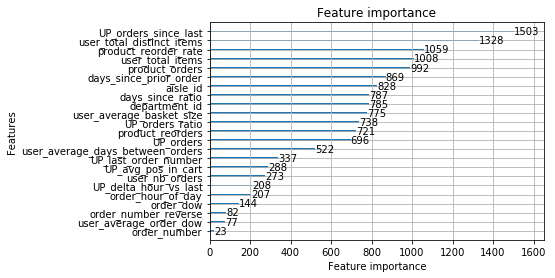

In [33]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=30)
plt.show()

Plot feature importances...


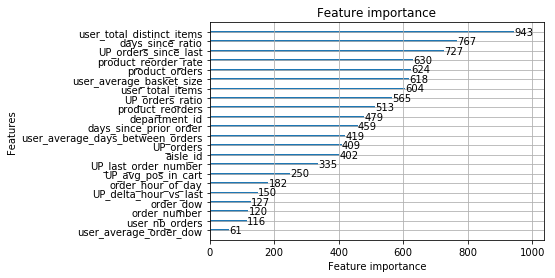

In [13]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=30)
plt.show()

In [34]:
df_test,_ = features(0,orders[orders.eval_set=='test'])
print('light gbm predict')
preds = bst.predict(df_test[f_to_use])
df_test['preds'] = preds

build candidate set
Building product features
Building user features
Building order features
Building user_product features
light gbm predict


In [35]:
threshold = 0.22
d = dict()
for row in df_test.itertuples():
    if row.preds > threshold:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in orders[orders.eval_set=='test'].order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')
sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv(ROOT_DIR+'paulantoine_lgb_starter.csv', index=False)

828824